# Illustrates the use of the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from paleopy import proxy
from paleopy import analogs
from paleopy import ensemble
from paleopy import WR
from paleopy.plotting import scalar_plot

In [4]:
proxies_num = pd.read_excel('../data/ProxiesLIANZSWP.xlsx', sheetname='numerical')

In [5]:
row = proxies_num.iloc[0,]

In [6]:
row

Site        Rarotonga
Lat            -21.23
Long          -159.82
Anom              0.6
dataset         ersst
variable          sst
Name: 0, dtype: object

In [7]:
djsons = '../jsons/'
pjsons = '../jsons/proxies'

In [8]:
p = proxy(sitename = row.Site,\
          lon = row.Long,\
          lat = row.Lat,\
          djsons = djsons,\
          pjsons = pjsons,\
          dataset = row.dataset,\
          variable = row.variable,\
          season = 'DJF',\
          value = row.Anom, \
          calc_anoms = False,\
          detrend=True)

In [ ]:
# extract the time-series
p.extract_ts()

print("{}{} --> {}{}: {} km".format(p.sitename, p.coords, p.variable, p.extracted_coords.tolist(), p.distance_point))

# calculates the season
p.calculate_season()

p.find_analogs()

In [ ]:
p.proxy_repr(pprint=True)

In [ ]:
f = p.plot_season_ts()

In [ ]:
from paleopy import WR

### try with a proxy object

In [ ]:
w = WR(p, classification='SW Pacific Regimes')

In [ ]:
obs_probs = w._get_compos_probs(w.analog_years)

In [ ]:
w.probs_anomalies()

In [ ]:
w.df_probs

that should fail with a size error exception, the heatmaps and bar plots will
only work if an ensemble object is passed

In [ ]:
w.plot_bar()

The following should work

### try with passing an `ensemble` object 

In [10]:
ens = ensemble(djsons=djsons, pjsons=pjsons, season='DJF')

In [18]:
classification = 'SW Pacific'
classification = 'New Zealand'

In [19]:
w = WR(ens, classification=classification)

In [20]:
w.parent.description

'ensemble'

In [21]:
w.climatology

[1981, 2010]

In [22]:
w.probs_anomalies(kind='many')

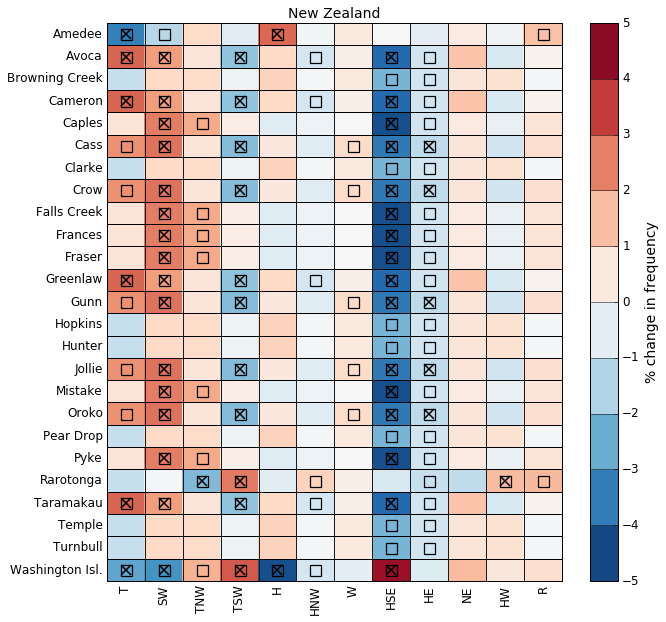

In [23]:
f = w.plot_heatmap()

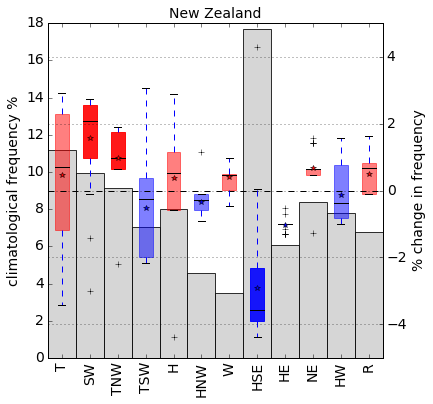

In [24]:
f = w.plot_bar()